# Residential Building Permits Issuance and Housing Violations

## Problem Description:
My motivation for this  assignment is to analyze how does the number of residential permits issuance correlate  with housing violations number, if at all, and by this to identify areas that should get more attention regarding building codes and building use validation. I relate to permit issuance as an indicator of urban renewal, due to the fact that the majority of construction in New York City requires a Department of Buildings permit to make sure that the plans are in compliance with Building Code (from nyc.gov).
   I pre assume that an area with a very low number of residential permits issued over a year (meaning, an area that is less developing / renewing) will also have a relatively large number of building violation (illegal conversion). I also guess there are  highly renewing areas with large number of permits issued and a large number of building violation complaints. Additionally, I am interested in assessing the roll of income in the predicting of housing violations. 

In [210]:
from __future__ import print_function, division
import sys
import os
import numpy as np
import pylab as pl
import pandas as pd
import geopandas as gpd
import fiona
import shapely
import json
import requests 
import urllib
import zipfile 
from pandas.tools.plotting import scatter_matrix

import scipy as sp
from scipy.cluster.vq import kmeans2, whiten
from sklearn import preprocessing
import statsmodels.formula.api as smf
import statsmodels.api as sm

import seaborn as sns
sns.set_style('whitegrid')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIDATA = os.getenv('PUIDATA')
print(PUIDATA)

/home/cusp/dcr346/PUIdata


# Data Acquiring

# 311 Building Violations complaints

Retrieved from [NYC Open Data](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/data) 

Data were filtered to include only **Building** related complaints prior downloading.<br>
Data were filtered to include **2016 complaints only** prior downloading.<br>
Descriptors included:
- Illegal Conversion Of Residential Building/Space
- Illegal Commercial Use In Resident Zone
- Zoning - Non-Conforming/Illegal Vehicle Storage
- No Certificate Of Occupancy/Illegal/Contrary To CO
- SRO - Illegal Work/No Permit/Change In Occupancy/Use
- ROOFING
- PORCH/BALCONY
- SKYLIGHT
- GUTTER/LEADER
- FENCING

In [426]:
# 311 DOB Complaints
# data had been filtered predownloading from NYC Open Data
df311 = pd.read_csv('https://raw.githubusercontent.com/danachermesh/PUI2017_dcr346/master/PUIextracredit_dcr346/311_Service_Requests_from_2010_to_Present.csv')
#df311 = (df311[df311['Complaint Type'] == 'Building/Use'])
#df311 = df311[['Created Date','Complaint Type','Descriptor','Borough','Latitude','Longitude','Location']]
df311.head()

,Unique Key,Created Date,Agency,Complaint Type,Descriptor,Incident Zip,Borough,Latitude,Longitude,Location
0,32312336,01/01/2016 12:39:45 AM,DOB,Building/Use,Illegal Conversion Of Residential Building/Space,11419.0,QUEENS,40.687433,-73.819974,"(40.68743272513059, -73.81997447956374)"
1,32311923,01/01/2016 01:40:42 AM,DOB,Building/Use,Illegal. Commercial Use In Resident Zone,11222.0,BROOKLYN,40.737750,-73.955904,"(40.737750323290356, -73.95590418542173)"
2,32312715,01/01/2016 02:27:53 AM,DOB,Building/Use,Illegal Conversion Of Residential Building/Space,11203.0,BROOKLYN,40.650954,-73.946448,"(40.65095398756497, -73.94644751706694)"
3,32312308,01/01/2016 05:49:28 AM,DOB,Building/Use,Illegal Conversion Of Residential Building/Space,11223.0,BROOKLYN,40.589427,-73.970973,"(40.589427305004506, -73.97097292630674)"
4,32311921,01/01/2016 09:08:11 AM,DOB,Building/Use,Illegal Conversion Of Residential Building/Space,11422.0,QUEENS,40.669736,-73.731794,"(40.669735526175856, -73.73179409270537)"


In [427]:
# getting only Residential permits
df311 = df311[df311['Descriptor'] != 'PAVEMENT']
df311 = df311[df311['Descriptor'] != 'Bikes in Buildings']
df311 = df311[df311['Descriptor'] != 'ROOF DOOR/HATCH']

# leaving unnecassary columns only
df311 = df311[['Incident Zip','Borough','Latitude','Longitude','Location']]
df311.columns = ['ZipCode','BOROUGH','Latitude','Longitude','Location']
#df311_clean = df311[['Incident Zip'],['Borough']]
df311.head()

,ZipCode,BOROUGH,Latitude,Longitude,Location
0,11419.0,QUEENS,40.687433,-73.819974,"(40.68743272513059, -73.81997447956374)"
1,11222.0,BROOKLYN,40.737750,-73.955904,"(40.737750323290356, -73.95590418542173)"
2,11203.0,BROOKLYN,40.650954,-73.946448,"(40.65095398756497, -73.94644751706694)"
3,11223.0,BROOKLYN,40.589427,-73.970973,"(40.589427305004506, -73.97097292630674)"
4,11422.0,QUEENS,40.669736,-73.731794,"(40.669735526175856, -73.73179409270537)"


In [428]:
df311 = df311.dropna(0)
df311['ZipCode'] = df311['ZipCode'].astype(int)
df311 = df311.groupby('ZipCode').count()

In [429]:
df311 = df311[['BOROUGH']]
df311.columns = ['BVcomplaints']
df311.head()

,BVcomplaints
ZipCode,
10001,70
10002,184
10003,87
10004,2
10005,4


# All 311 complaints data for normalizing housing violation complaints data

Retrieved from [NYC Open Data](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/data) 

**All 311 complaints for year 2016** were calculated in a separate [Ipython notebook](https://github.com/danachermesh/PUI2017_dcr346/blob/master/PUIextracredit_dcr346/311Allcomplaints_data.ipynb)

In [446]:
all311 = pd.read_csv('https://raw.githubusercontent.com/danachermesh/PUI2017_dcr346/master/PUIextracredit_dcr346/311allcomplaints.csv')
all311 = all311[5:]
all311.head()

,Incident Zip,allcomplaints
5,10000,120
6,10001,14358
7,10002,19164
8,10003,17220
9,10004,1710


In [561]:
# merge with 311 buildings related complaints

norm311 = df311.merge(all311, left_index=True, right_on='Incident Zip')
norm311 = norm311.set_index('Incident Zip')
norm311['BVnorm'] = norm311['BVcomplaints'] / norm311['allcomplaints'] * 10000
norm311 = norm311[['BVnorm']]

norm311.head()

,BVnorm
Incident Zip,
10001,48.753308
10002,96.013358
10003,50.522648
10004,11.695906
10005,15.540016


# DOB Permits Issuance Data
Retrieved from https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a/data

In [448]:
permits = pd.read_csv('https://data.cityofnewyork.us/api/views/ipu4-2q9a/rows.csv?accessType=DOWNLOAD')
permits.head()

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,...,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,PERMIT_SI_NO,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,CENSUS_TRACT,NTA_NAME
0,BROOKLYN,3326733,1070,EAST 104 STREET,301064023,1,A2,Y,8230,1,...,NY,11101,7184728000,11/03/2017 12:00:00 AM,1238812,40.644203,-73.892264,46.0,986.0,Canarsie
1,BROOKLYN,3322563,230,HANCOCK STREET,302036375,1,A1,Y,1838,43,...,NV,11225,NaN,11/03/2017 12:00:00 AM,2471045,40.682849,-73.947219,36.0,249.0,Bedford
2,MANHATTAN,1040756,504,PARK AVENUE,100209846,1,A3,NaN,1374,36,...,NY,10017,2127542310,11/03/2017 12:00:00 AM,191966,40.763075,-73.969695,4.0,11401.0,Upper East Side-Carnegie Hill
3,MANHATTAN,1036459,570,LEXINGTON AVENUE,101464835,1,A2,NaN,1305,60,...,NY,10022,2125571100,11/03/2017 12:00:00 AM,679627,40.756925,-73.972066,4.0,100.0,Turtle Bay-East Midtown
4,MANHATTAN,1015847,25,W. 32 ST.,122488478,1,A2,Y,834,26,...,NY,11354,9178283018,11/03/2017 12:00:00 AM,3044504,40.747535,-73.986372,4.0,76.0,Midtown-Midtown South


In [449]:
permits.columns

Index([u'BOROUGH', u'Bin #', u'House #', u'Street Name', u'Job #',
       u'Job doc. #', u'Job Type', u'Self_Cert', u'Block', u'Lot',
       u'Community Board', u'Zip Code', u'Bldg Type', u'Residential',
       u'Special District 1', u'Special District 2', u'Work Type',
       u'Permit Status', u'Filing Status', u'Permit Type',
       u'Permit Sequence #', u'Permit Subtype', u'Oil Gas', u'Site Fill',
       u'Filing Date', u'Issuance Date', u'Expiration Date', u'Job Start Date',
       u'Permittee's First Name', u'Permittee's Last Name',
       u'Permittee's Business Name', u'Permittee's Phone #',
       u'Permittee's License Type', u'Permittee's License #',
       u'Act as Superintendent', u'Permittee's Other Title', u'HIC License',
       u'Site Safety Mgr's First Name', u'Site Safety Mgr's Last Name',
       u'Site Safety Mgr Business Name', u'Superintendent First & Last Name',
       u'Superintendent Business Name', u'Owner's Business Type',
       u'Non-Profit', u'Owner's Business

In [450]:
permits = permits[['BOROUGH','Zip Code','Bldg Type','Residential','Permit Type','Issuance Date']]

permits.head()

,BOROUGH,Zip Code,Bldg Type,Residential,Permit Type,Issuance Date
0,BROOKLYN,11236.0,2.0,NaN,EW,09/16/2002 12:00:00 AM
1,BROOKLYN,11216.0,1.0,YES,EQ,12/28/2012 12:00:00 AM
2,MANHATTAN,10022.0,2.0,YES,AL,11/27/1991 12:00:00 AM
3,MANHATTAN,10022.0,2.0,NaN,PL,03/24/1997 12:00:00 AM
4,MANHATTAN,10001.0,2.0,NaN,EW,03/30/2016 12:00:00 AM


In [451]:
# getting only Residential permits
permits = permits[permits['Residential'] == 'YES']
permits.shape

(1245879, 6)

In [452]:
# getting only New Building (NB) and Alternation (AL) permits
permitsAL = permits[permits['Permit Type'] == 'AL']
permitsNB = permits[permits['Permit Type'] == 'NB']

In [453]:
permits = pd.concat([permitsNB, permitsAL], axis=0)
permits = permits[['BOROUGH','Zip Code','Issuance Date']]
permits.shape

(356382, 3)

In [454]:
# getting only permits that were issued in 2016
# converting date to datetime format, date only
permits['date'] = pd.to_datetime(permits['Issuance Date'])

permits.head()

,BOROUGH,Zip Code,Issuance Date,date
7,BROOKLYN,11216.0,05/17/2000 12:00:00 AM,2000-05-17
14,BROOKLYN,11221.0,10/22/2015 12:00:00 AM,2015-10-22
55,STATEN ISLAND,10303.0,10/06/2003 12:00:00 AM,2003-10-06
58,BRONX,10456.0,12/07/2001 12:00:00 AM,2001-12-07
96,BROOKLYN,11238.0,12/02/1994 12:00:00 AM,1994-12-02


In [455]:
permits['year'] = permits['date'].dt.year

In [456]:
permits.dtypes

BOROUGH                  object
Zip Code                float64
Issuance Date            object
date             datetime64[ns]
year                    float64
dtype: object

In [457]:
permits16 = permits[permits['year'] == 2016]
permits16 = permits[['BOROUGH','Zip Code']]
permits16.shape

(356382, 2)

In [458]:
permits16 = permits16.dropna(0)

In [459]:
permits16['Zip Code'] = permits16['Zip Code'].astype(int)
permits16.head()

,BOROUGH,Zip Code
7,BROOKLYN,11216
14,BROOKLYN,11221
55,STATEN ISLAND,10303
58,BRONX,10456
96,BROOKLYN,11238


In [460]:
permits16 = permits16.groupby('Zip Code').count()
permits16.columns = ['permitissued']
permits16.head()

,permitissued
Zip Code,
0,2
4452,3
10001,844
10002,1559
10003,1988


In [461]:
permits16.shape

(187, 1)

# PLUTO data 
This data is obtained in order to normalize the DOB permits + violations above (_no. of housing units_)

In [462]:
#reading in my api key saved in censusAPI.py as
#myAPI = 'XXXXXXXXXXXXXXX'
from censusAPI import myAPI

In [463]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs5/subject/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [464]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

In [465]:
#keyword for the number of renter-occupied households
keyNrenters = 'S2504_C03_001E'
#keyNhousingunits = 'S1101_C01_020E'
aff1y['variables'][keyNrenters]

{u'attributes': u'S2504_C03_001M,S2504_C03_001MA,S2504_C03_001EA',
 u'concept': u'PHYSICAL HOUSING CHARACTERISTICS FOR OCCUPIED HOUSING UNITS',
 u'group': u'S2504',
 u'label': u'Renter-occupied housing units!!Estimate!!Occupied housing units',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [466]:
#keyword for the number of Owner-occupied households
keyNowner = 'S2504_C02_001E'
#keyNhousingunits = 'S1101_C01_019E'
aff1y['variables'][keyNowner]

{u'attributes': u'S2504_C02_001M,S2504_C02_001MA,S2504_C02_001EA',
 u'concept': u'PHYSICAL HOUSING CHARACTERISTICS FOR OCCUPIED HOUSING UNITS',
 u'group': u'S2504',
 u'label': u'Owner-occupied housing units!!Estimate!!Occupied housing units',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [467]:
#keyword for the number of total occupied housing units
keyNhousingunits = 'S2504_C01_001E'
#keyNhousingunits = 'S1101_C01_001E'
aff1y['variables'][keyNhousingunits]

{u'attributes': u'S2504_C01_001M,S2504_C01_001MA,S2504_C01_001EA',
 u'concept': u'PHYSICAL HOUSING CHARACTERISTICS FOR OCCUPIED HOUSING UNITS',
 u'group': u'S2504',
 u'label': u'Occupied housing units!!Estimate!!Occupied housing units',
 u'limit': 0,
 u'predicateType': u'int',
 u'validValues': []}

In [468]:
import io

#getting the first row of the table: the total number of housing units
url = "https://api.census.gov/data/2016/acs/acs5/subject?get=NAME," + keyNowner +\
"&for=zip%20code%20tabulation%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content

#Housingunits = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
#Housingunits.head()

### Getting Housing Units number for NYC zipcodes

In [469]:
Housingunits = pd.read_csv('https://api.census.gov/data/2016/acs/acs5/subject?get=NAME,' + keyNhousingunits + '&for=zip%20code%20tabulation%20area:*')
Housingunits = Housingunits[['S2504_C01_001E','zip code tabulation area]']]
Housingunits.columns = ['HousingUnits', 'zipcode']
Housingunits = Housingunits[Housingunits['zipcode'].astype(str).str.startswith('1')]

Housingunits.head()

,HousingUnits,zipcode
2558,11967,10001]
2559,33327,10002]
2560,27258,10003]
2561,1592,10004]
2562,4295,10005]


In [470]:
for i in range(len(Housingunits.iloc[:, 1])):
    Housingunits.iloc[i,1] = Housingunits.iloc[i,1][:5]

    
Housingunits.head()

,HousingUnits,zipcode
2558,11967,10001
2559,33327,10002
2560,27258,10003
2561,1592,10004
2562,4295,10005


### Getting Renter-occupied Housing Units number for NYC zipcodes

In [471]:
renters = pd.read_csv('https://api.census.gov/data/2016/acs/acs5/subject?get=NAME,' + keyNrenters + '&for=zip%20code%20tabulation%20area:*')
renters = renters[['S2504_C03_001E','zip code tabulation area]']]
renters.columns = ['rentersoccupied', 'zipcode']
renters = renters[renters['zipcode'].astype(str).str.startswith('1')]
for i in range(len(renters.iloc[:, 1])):
    renters.iloc[i,1] = renters.iloc[i,1][:5]

renters.head()

,rentersoccupied,zipcode
2558,8735,10001
2559,28726,10002
2560,18966,10003
2561,1162,10004
2562,3546,10005


### Getting Owner-occupied Housing Units number for NYC zipcodes

In [472]:
owners = pd.read_csv('https://api.census.gov/data/2016/acs/acs5/subject?get=NAME,' + keyNowner + '&for=zip%20code%20tabulation%20area:*')
owners = owners[['S2504_C02_001E','zip code tabulation area]']]
owners.columns = ['ownersoccupied', 'zipcode']
owners = owners[owners['zipcode'].astype(str).str.startswith('1')]
for i in range(len(owners.iloc[:, 1])):
    owners.iloc[i,1] = owners.iloc[i,1][:5]

owners.head()

,ownersoccupied,zipcode
2558,3232,10001
2559,4601,10002
2560,8292,10003
2561,430,10004
2562,749,10005


### Merging Census Data

In [549]:
Housingunitsall = Housingunits.merge(owners, on='zipcode')
Housingunitsall = Housingunitsall.merge(renters, on='zipcode')
#Housingunitsall = Housingunitsall.set_index('zipcode')

Housingunitsall['renrownRatio'] = Housingunitsall['rentersoccupied'] / Housingunitsall['ownersoccupied']
Housingunitsall['renterPerc'] = Housingunitsall['rentersoccupied'] / Housingunitsall['HousingUnits'] *100
Housingunitsall['ownerrPerc'] = Housingunitsall['ownersoccupied'] / Housingunitsall['HousingUnits'] *100
Housingunitsall = Housingunitsall.dropna(0)

Housingunitsall.head()

,HousingUnits,zipcode,ownersoccupied,rentersoccupied,renrownRatio,renterPerc,ownerrPerc
0,11967,10001,3232,8735,2.702661,72.992396,27.007604
1,33327,10002,4601,28726,6.243425,86.194377,13.805623
2,27258,10003,8292,18966,2.287265,69.579573,30.420427
3,1592,10004,430,1162,2.702326,72.989950,27.010050
4,4295,10005,749,3546,4.734312,82.561118,17.438882


## NYC Zipcodes shp for Spatial Analysis

In [475]:
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
os.system("unzip -d %s ZIP_CODE.zip"%(os.getenv('PUIDATA')))
zipshp = gpd.GeoDataFrame.from_file(PUIDATA + '/ZIP_CODE_040114.shp')
zipshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [476]:
zipshp.shape

(263, 13)

## Merging variables' dataframes

In [562]:
BV_permits = permits16.merge(norm311, left_index=True, right_index=True)
BV_permits.head()

,permitissued,BVnorm
10001,844,48.753308
10002,1559,96.013358
10003,1988,50.522648
10004,108,11.695906
10005,139,15.540016


In [554]:
BV_permits.shape

(176, 2)

## Standardizing data with sklearn preprocessing 

In [558]:
#BV_permits_scaled = preprocessing.scale(BV_permits)
#BV_permits_scaled = pd.DataFrame(BV_permits_scaled)
#BV_permits_scaled.head()

,0,1
0,-0.777498,-0.754426
1,-0.305642,-0.386293
2,-0.022528,-0.740644
3,-1.263213,-1.043085
4,-1.242755,-1.013142


In [559]:
#BV_permits_scaled.std()

0    1.002853
1    1.002853
dtype: float64

In [563]:
Housingunitsall['zipcode'] = Housingunitsall['zipcode'].astype(int)

In [564]:
BV_permits = BV_permits.merge(Housingunitsall, left_index=True, right_on='zipcode')
BV_permits = BV_permits.set_index('zipcode')
BV_permits.head()

,permitissued,BVnorm,HousingUnits,ownersoccupied,rentersoccupied,renrownRatio,renterPerc,ownerrPerc
zipcode,,,,,,,,
10001,844,48.753308,11967,3232,8735,2.702661,72.992396,27.007604
10002,1559,96.013358,33327,4601,28726,6.243425,86.194377,13.805623
10003,1988,50.522648,27258,8292,18966,2.287265,69.579573,30.420427
10004,108,11.695906,1592,430,1162,2.702326,72.989950,27.010050
10005,139,15.540016,4295,749,3546,4.734312,82.561118,17.438882


## Normalize by number of housing units

In [565]:
BV_permits_norm = BV_permits
# Permits per Housing Unit
BV_permits_norm['permitNorm'] = BV_permits_norm['permitissued'] / BV_permits_norm['HousingUnits'] * 1000
# Building violation complaints Housing Unit
#BV_permits_norm['bvPHU'] = BV_permits_norm['311complaints'] / BV_permits_norm['HousingUnits'] * 1000
BV_permits_norm = BV_permits_norm[['permitNorm','BVnorm','HousingUnits','renrownRatio','renterPerc','ownerrPerc']]

BV_permits_norm.head()

,permitNorm,BVnorm,HousingUnits,renrownRatio,renterPerc,ownerrPerc
zipcode,,,,,,
10001,70.527283,48.753308,11967,2.702661,72.992396,27.007604
10002,46.778888,96.013358,33327,6.243425,86.194377,13.805623
10003,72.932717,50.522648,27258,2.287265,69.579573,30.420427
10004,67.839196,11.695906,1592,2.702326,72.989950,27.010050
10005,32.363213,15.540016,4295,4.734312,82.561118,17.438882


## Merge with Zipcode shp

In [566]:
zipshp['ZIPCODE'] = zipshp['ZIPCODE'].astype(int)

In [567]:
BV_permits_shp = zipshp.merge(BV_permits_norm, left_on='ZIPCODE',right_index=True)
BV_permits_shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,permitNorm,BVnorm,HousingUnits,renrownRatio,renterPerc,ownerrPerc
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",176.738260,396.018636,5494,0.432968,30.214780,69.785220
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",82.546688,66.512187,24471,5.814536,85.325487,14.674513
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",54.642733,84.011552,31587,5.682251,85.034983,14.965017
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",46.888974,48.412899,23481,5.955273,85.622418,14.377582
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",72.546634,110.672803,24660,1.903568,65.559611,34.440389


In [569]:
BV_permits_shp = BV_permits_shp[['ZIPCODE','POPULATION','COUNTY','geometry','BVnorm','permitNorm','HousingUnits','renrownRatio','renterPerc','ownerrPerc']]
BV_permits_shp = BV_permits_shp.set_index('ZIPCODE')
BV_permits_shp.head()

,POPULATION,COUNTY,geometry,BVnorm,permitNorm,HousingUnits,renrownRatio,renterPerc,ownerrPerc
ZIPCODE,,,,,,,,,
11436,18681.0,Queens,"POLYGON ((1038098.251871482 188138.3800067157,...",396.018636,176.738260,5494,0.432968,30.214780,69.785220
11213,62426.0,Kings,"POLYGON ((1001613.712964058 186926.4395172149,...",66.512187,82.546688,24471,5.814536,85.325487,14.674513
11212,83866.0,Kings,"POLYGON ((1011174.275535807 183696.33770971, 1...",84.011552,54.642733,31587,5.682251,85.034983,14.965017
11225,56527.0,Kings,"POLYGON ((995908.3654508889 183617.6128015518,...",48.412899,46.888974,23481,5.955273,85.622418,14.377582
11218,72280.0,Kings,"POLYGON ((991997.1134308875 176307.4958601296,...",110.672803,72.546634,24660,1.903568,65.559611,34.440389


___

# Analysis

# 1. Descriptive Statistics

In [570]:
BV_permits_norm.columns

Index([u'permitNorm', u'BVnorm', u'HousingUnits', u'renrownRatio',
       u'renterPerc', u'ownerrPerc'],
      dtype='object')

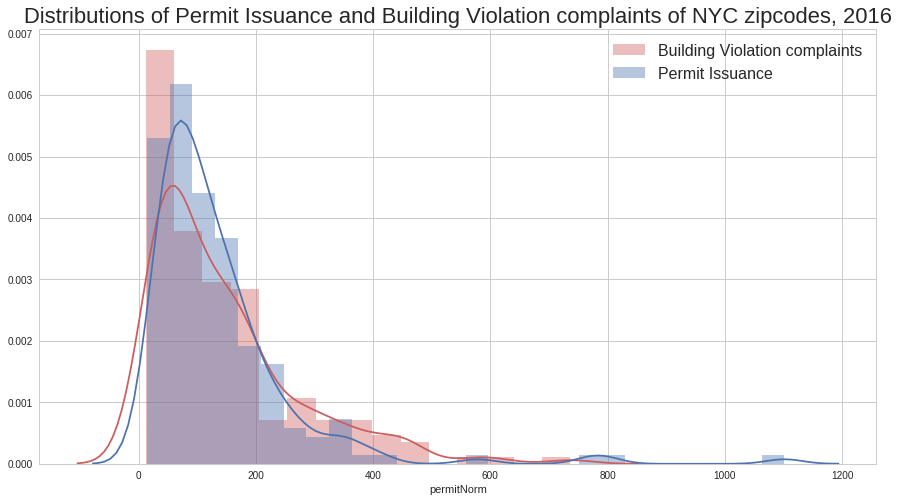

In [571]:
# plot histogram of both variables

pl.figure(figsize = (15,8))

sns.distplot(BV_permits_norm['BVnorm'], color="IndianRed", label='Building Violation complaints');
sns.distplot(BV_permits_norm['permitNorm'], label='Permit Issuance');
sns.set_style("whitegrid")
pl.title('Distributions of Permit Issuance and Building Violation complaints of NYC zipcodes, 2016', fontsize=22)
pl.legend(fontsize=16)

## Fig.1 Distribution of Permit Issuance and Building Violation complaints of NYC zipcodes, 2016
The distributions of the two variables seems to be not very different.

In [169]:
BV_permits_norm.index[::10]

Int64Index([11436, 10471, 10469, 10457, 10473, 10035, 10028, 11106, 10016,
            10012, 10004, 11217, 11239, 11693, 11692, 10280, 11366, 11221,
            10075],
           dtype='int64', name=u'ZIPCODE')

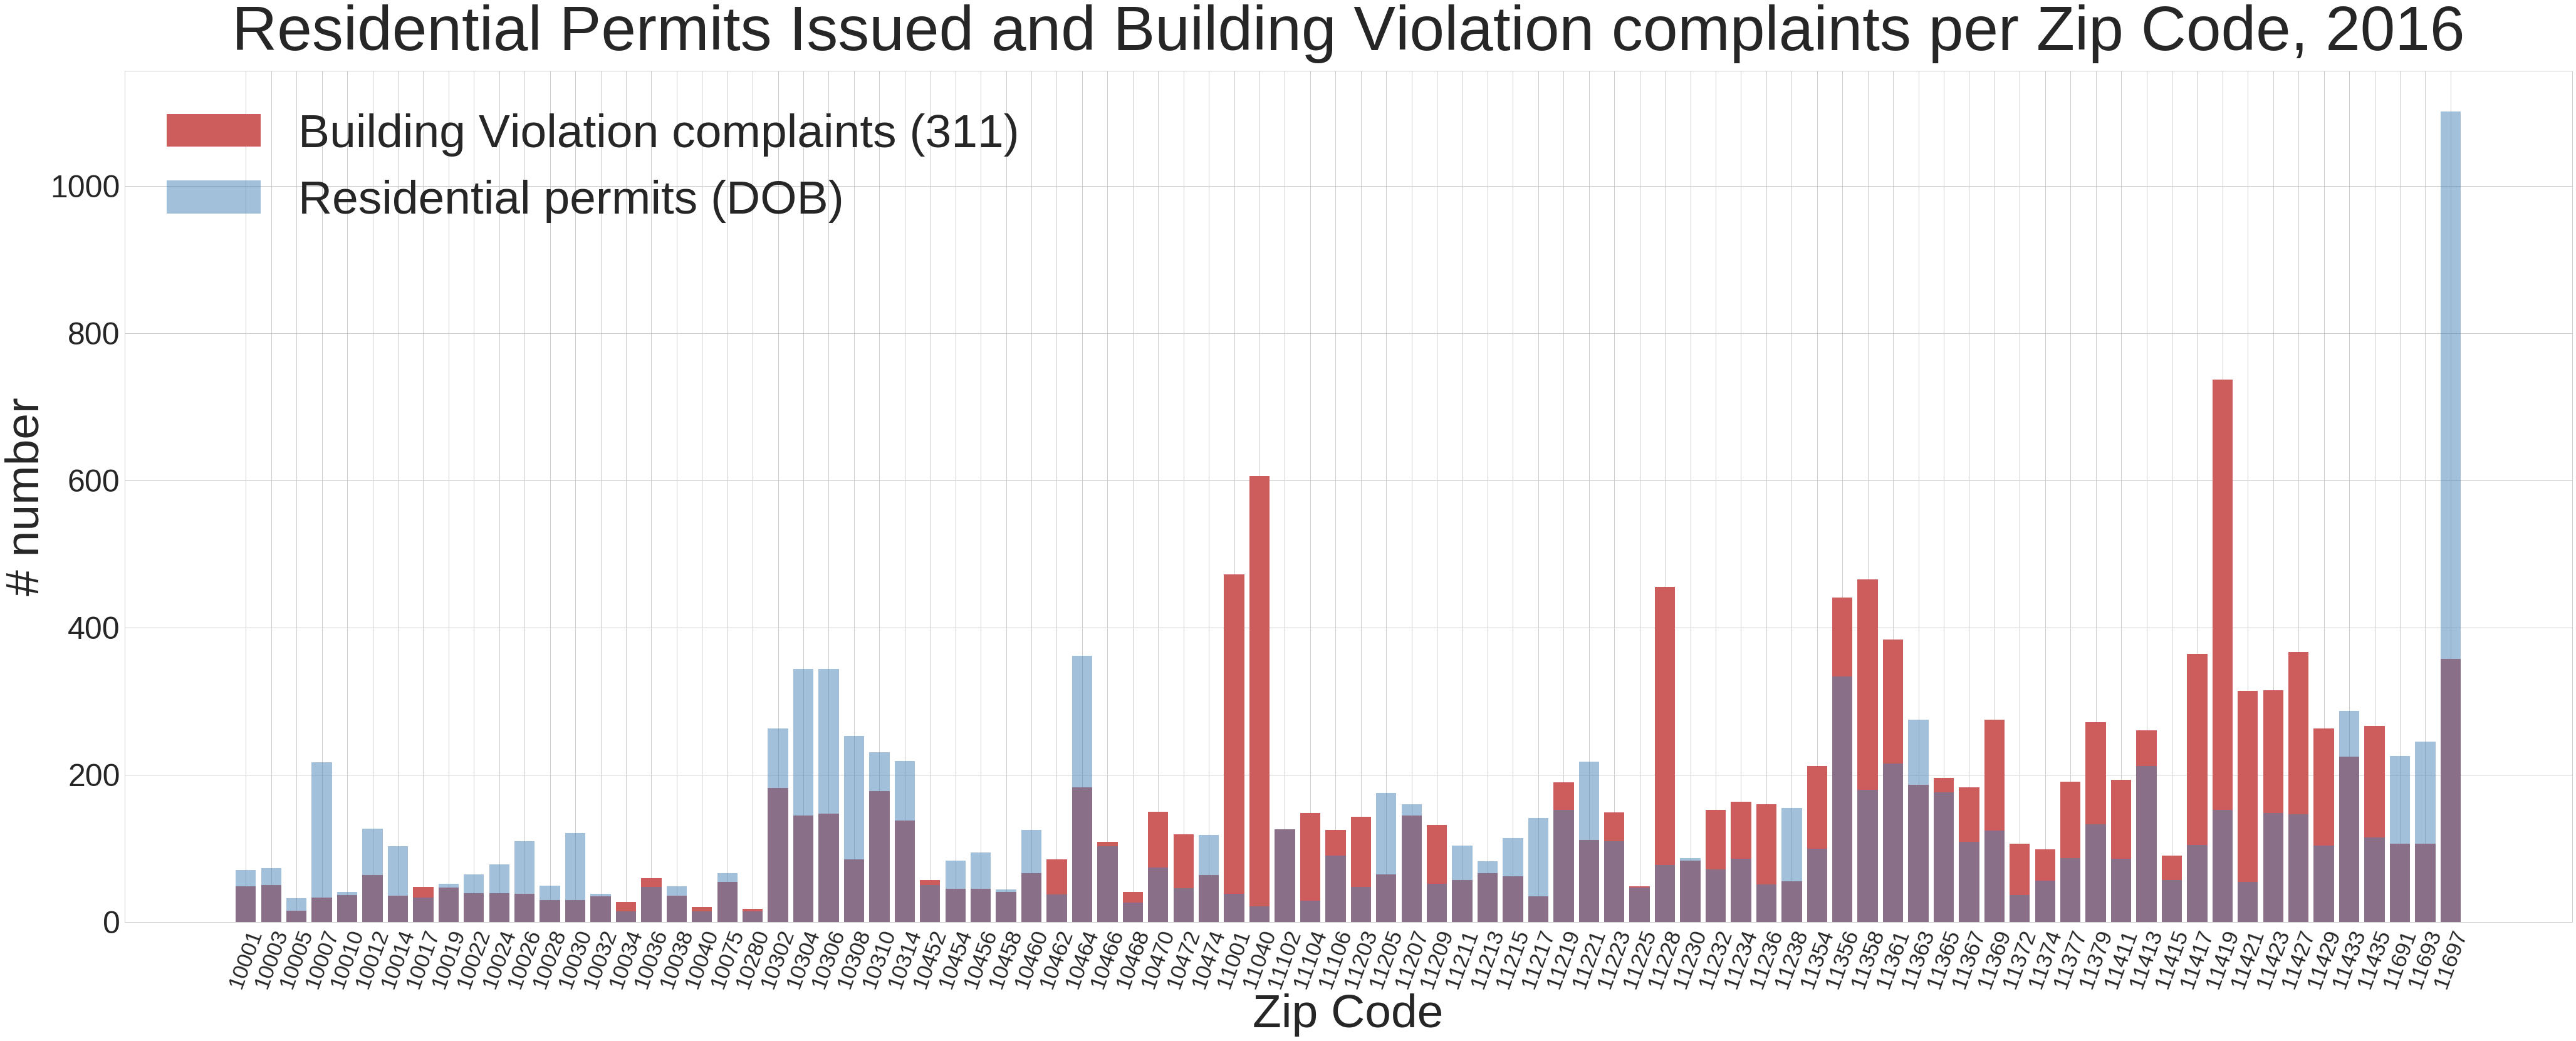

In [572]:
pl.figure(figsize = (70,25))

pl.bar(range(len(BV_permits_norm[::2])), BV_permits_norm['BVnorm'][::2], align='center', color="IndianRed",\
label='Building Violation complaints (311)')
ax = pl.bar(range(len(BV_permits_norm[::2])), BV_permits_norm["permitNorm"][::2], align='center', color="SteelBlue", alpha=0.5,\
label='Residential permits (DOB)')
pl.xticks(range(len(BV_permits_norm[::2])), BV_permits_norm.index[::2], fontsize = 35, rotation=70)
pl.yticks(fontsize = 50)

sns.set_style("whitegrid")
pl.xlabel('Zip Code', fontsize=75)
pl.ylabel('# number', fontsize=75)
pl.title('Residential Permits Issued and Building Violation complaints per Zip Code, 2016', fontsize=100, y=1.02)
pl.legend(prop={'size': 75})

## Fig.2 Residential Permits Issued and Building Violation complaints per Zip Code, 2016
The bar plot of the two variables does not give us much information about any possible relationship between them.

# 2. Understanding if Permits Issuance follows a Gaussian distribution
#### Statistical test to assess if the distribution is Gaussian
#### AD test, parametric
To assess if the distribution is in fact consistent with a Gaussian I will set a significance threshold of **0.05** and test the standardized distribution against a standard normal distribution with an Anderson Darling test.

In [490]:
# statistical significance threshold
alpha = 0.05

# AD test
adPermits = sp.stats.anderson((BV_permits_norm.permitNorm - 
                BV_permits_norm.permitNorm.mean())  / 
                    BV_permits_norm.permitNorm.std(), "norm")
verb = "does not " if adPermits[0] > adPermits[1][adPermits[2] == alpha * 100] else "does "
print ("The distribution of tips " + verb + "follow a normal distribution (p < 0.05) " + 
      "according to the AD test")

The distribution of tips does not follow a normal distribution (p < 0.05) according to the AD test


# 3. Modeling to assess colinearity Permits Issuance and Building Violations

In [573]:
# modeling BV complaints with permits issuance
BV_permit_model = smf.ols(formula='BVnorm ~ permitNorm', data=BV_permits_norm).fit()
BV_permit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BVnorm   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     10.94
Date:                Thu, 14 Dec 2017   Prob (F-statistic):            0.00114
Time:                        17:21:16   Log-Likelihood:                -1092.8
No. Observations:                 175   AIC:                             2190.
Df Residuals:                     173   BIC:                             2196.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    114.0167     13.572      8.401      0.000        87.229   140.804
permitNorm     0.2336      0.071      3.308      0.001         0.094     0.373
==============================================================================
Omnibus:                       74.918   Durbin-Watson:                   0.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.932
Skew:                           1.835   Prob(JB):                     7.05e-46
Kurtosis:                       6.879   Cond. No.                         275.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Permit Issuance model has very low predictive power on number of Building Violation. However the distribution of building violation has not been evaluated yet

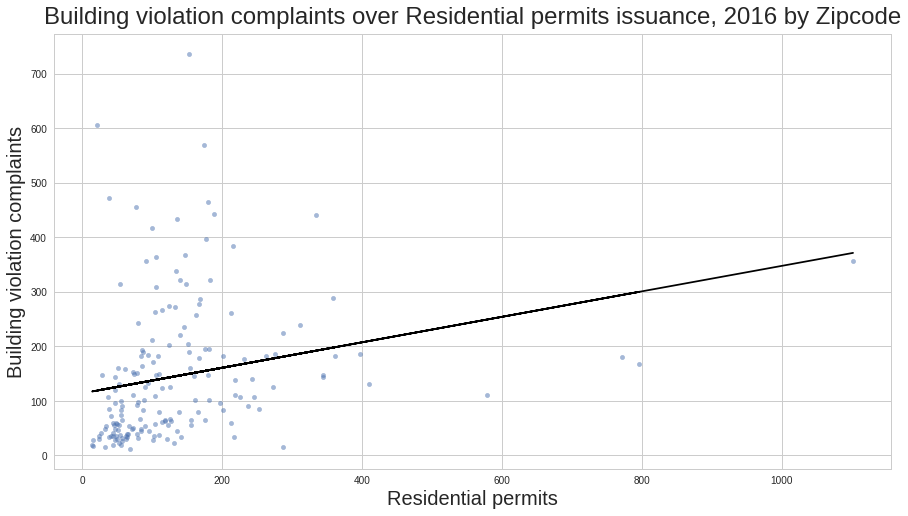

In [574]:
ax = BV_permits_norm.plot.scatter(y="BVnorm", x="permitNorm", alpha=0.5)
ax.plot(BV_permits_norm.permitNorm, BV_permit_model.fittedvalues, 'k')
ax.set_title("Building violation complaints over Residential permits issuance, 2016 by Zipcode", fontsize=24, y=1.01)
ax.set_ylabel("Building violation complaints", fontsize = 20)
ax.set_xlabel("Residential permits", fontsize = 20);

## Fig.3 Building violation complaints over Residential permits issuance, 2016 by Zipcode + linear fitted line
The fitted line does not seem to explain the data sufficiently.

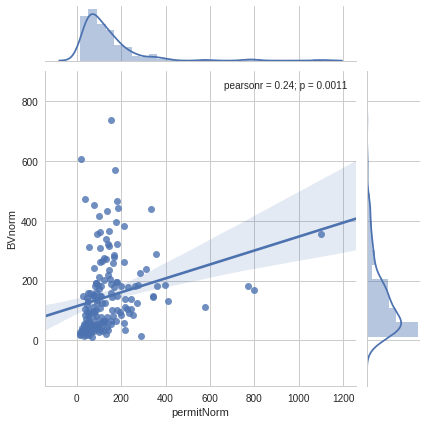

In [494]:
sns.jointplot(x="permitNorm", y="BVnorm", data=BV_permits_norm, kind="reg")

In [ ]:
# plot errorbar

# ax3.errorbar(df['firearmspp'], df['shootingspp'],
             #yerr=np.sqrt(df['shootingspp']), label='y', fmt='.')

## Understanding outliers in the data ( > mean + 2*std )

In [495]:
# removing upper 2.5% (mean + 2 stdev) and <0 rides by duration

BV_permits_norm.permitNorm.describe()

count     175.000000
mean      137.543884
std       134.580676
min        13.987318
25%        56.665304
50%       104.118839
75%       166.667659
max      1101.604278
Name: permitNorm, dtype: float64

In [510]:
threshold = BV_permits_norm.permitNorm.mean() + 2 * BV_permits_norm.permitNorm.std()
print("no. of zipcode permits (normalized) treshold is: ", threshold)
np.where(BV_permits_norm.permitNorm > threshold)

no. of zipcode permits (normalized) treshold is:  406.705235315


(array([ 47,  49,  51, 171, 174]),)

In [519]:
print("Zipcodes that are outliers in the sense of no. of permits issued are:\n")
print(BV_permits_norm.permitNorm.index[47])
print(BV_permits_norm.permitNorm.index[49])
print(BV_permits_norm.permitNorm.index[51])
print(BV_permits_norm.permitNorm.index[171])
print(BV_permits_norm.permitNorm.index[174])

Zipcodes that are outliers in the sense of no. of permits issued are:

10307
10309
10312
11692
11697


## To understand where the outliers are I will refer to [Zipcode definitions list](https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm)

According to the above, the outliers are at _**Rockaways, Queens**_ and _**South Shore, SI**_

In [520]:
# Outliers of 

threshold2 = BV_permits_norm.BVnorm.mean() + 2 * BV_permits_norm.BVnorm.std()
print("no. of zipcode BV complaints (normalized) treshold is: ", threshold2)
np.where(BV_permits_norm.BVnorm > threshold2)

no. of zipcode BV complaints (normalized) treshold is:  403.96939663


(array([ 78,  80, 112, 125, 126, 128, 156, 157, 161, 163]),)

In [521]:
print("Zipcodes that are outliers in the sense of no. of BV complaints are:\n")
print(BV_permits_norm.BVnorm.index[78])
print(BV_permits_norm.BVnorm.index[80])
print(BV_permits_norm.BVnorm.index[112])
print(BV_permits_norm.BVnorm.index[125])
print(BV_permits_norm.BVnorm.index[126])
print(BV_permits_norm.BVnorm.index[128])
print(BV_permits_norm.BVnorm.index[156])
print(BV_permits_norm.BVnorm.index[157])
print(BV_permits_norm.BVnorm.index[161])
print(BV_permits_norm.BVnorm.index[163])

Zipcodes that are outliers in the sense of no. of BV complaints are:

11001
11040
11228
11355
11356
11358
11419
11420
11426
11428


Using again the [Zipcode definitions list](https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm), there are two outliers that are not from NYC; The other outliers of BV complaints are in _**North Queens**_ and _**Southeast Queens**_,  and one outlier in _**Southwest Brooklyn**_.

Having considering the outliers for both variables, I choose to zoom in my analysis to include **Manhattan and Brooklyn only**.

## Reduced df to MAN & BKN and run statistics again + distribution

In [575]:
BVpermit_MAN = BV_permits_norm[BV_permits_norm.index.astype(str).str.startswith('100')]
BVpermit_BKN = BV_permits_norm[BV_permits_norm.index.astype(str).str.startswith('112')]

BVpermit_cut = pd.concat([BVpermit_MAN, BVpermit_BKN], axis=0)
BVpermit_cut.head()

,permitNorm,BVnorm,HousingUnits,renrownRatio,renterPerc,ownerrPerc
zipcode,,,,,,
10001,70.527283,48.753308,11967,2.702661,72.992396,27.007604
10002,46.778888,96.013358,33327,6.243425,86.194377,13.805623
10003,72.932717,50.522648,27258,2.287265,69.579573,30.420427
10004,67.839196,11.695906,1592,2.702326,72.989950,27.010050
10005,32.363213,15.540016,4295,4.734312,82.561118,17.438882


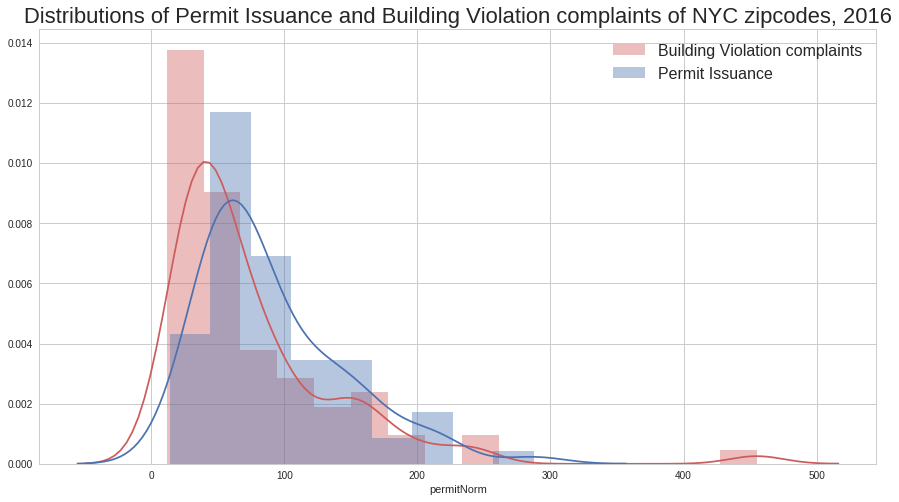

In [526]:
# plot histogram of both variables

pl.figure(figsize = (15,8))

sns.distplot(BVpermit_cut['BVnorm'], color="IndianRed", label='Building Violation complaints');
sns.distplot(BVpermit_cut['permitNorm'], label='Permit Issuance');
sns.set_style("whitegrid")
pl.title('Distributions of Permit Issuance and Building Violation complaints of NYC zipcodes, 2016', fontsize=22)
pl.legend(fontsize=16)

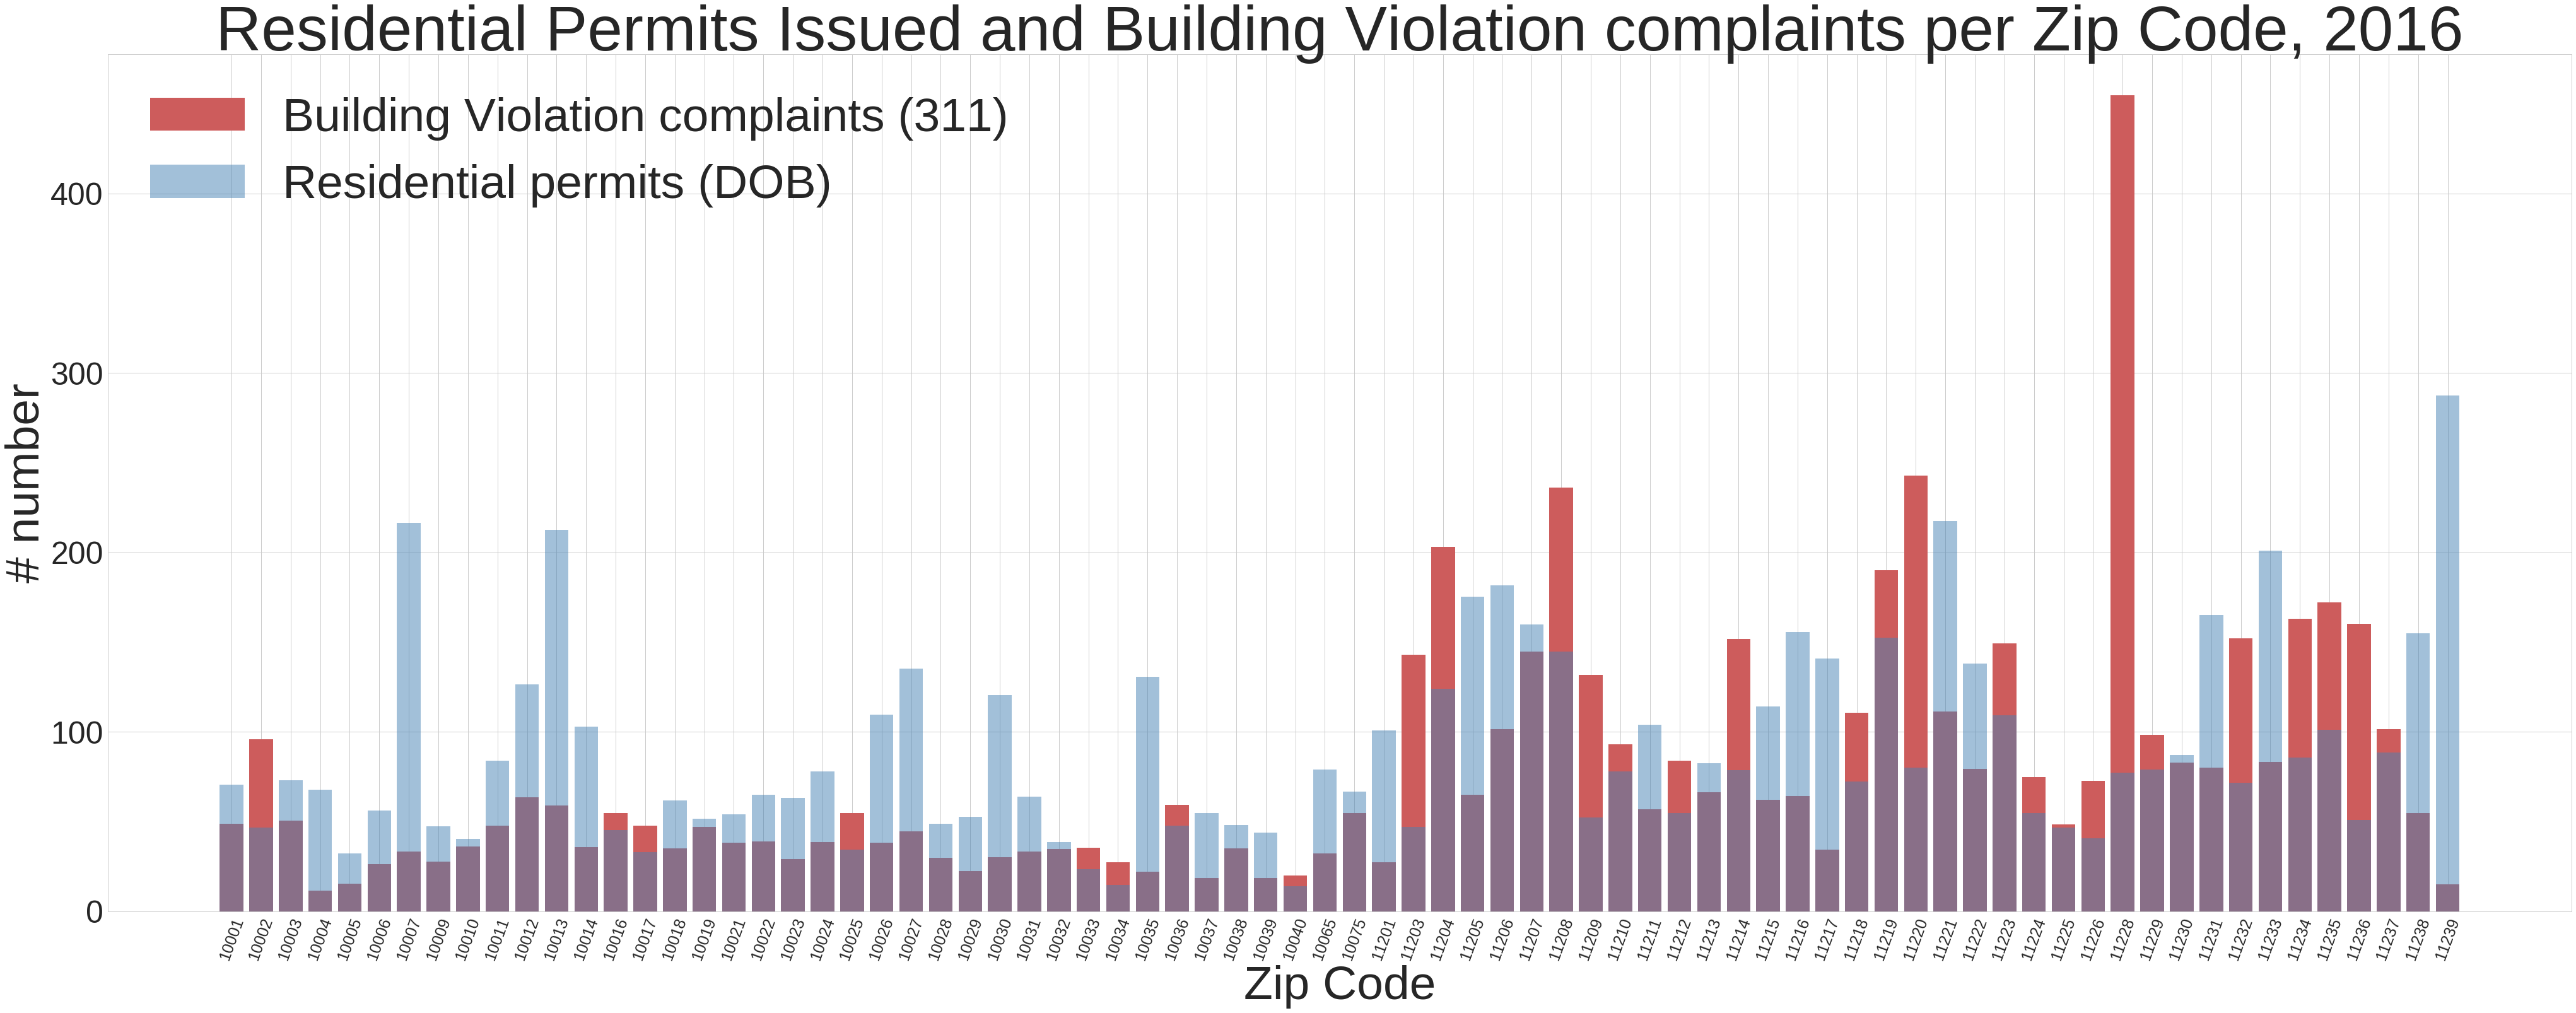

In [535]:
pl.figure(figsize = (70,25))

pl.bar(range(len(BVpermit_cut)), BVpermit_cut['BVnorm'], align='center', color="IndianRed",\
label='Building Violation complaints (311)')
ax = pl.bar(range(len(BVpermit_cut)), BVpermit_cut["permitNorm"], align='center', color="SteelBlue", alpha=0.5,\
label='Residential permits (DOB)')
pl.xticks(range(len(BVpermit_cut)), BVpermit_cut.index, fontsize = 25, rotation=70)
pl.yticks(fontsize = 50)

sns.set_style("whitegrid")
pl.xlabel('Zip Code', fontsize=75)
pl.ylabel('# number', fontsize=75)
pl.title('Residential Permits Issued and Building Violation complaints per Zip Code, 2016', fontsize=100)
pl.legend(prop={'size': 75})

In [576]:
# modeling BV complaints with permits issuance
BVP_model2 = smf.ols(formula='BVnorm ~ permitNorm', data=BVpermit_MAN).fit()
BVP_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BVnorm   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8235
Date:                Thu, 14 Dec 2017   Prob (F-statistic):              0.370
Time:                        18:10:56   Log-Likelihood:                -162.63
No. Observations:                  39   AIC:                             329.3
Df Residuals:                      37   BIC:                             332.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     34.6186      4.816      7.189      0.000        24.861    44.376
permitNorm     0.0522      0.058      0.907      0.370        -0.064     0.169
==============================================================================
Omnibus:                       17.622   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.502
Skew:                           1.266   Prob(JB):                     2.90e-06
Kurtosis:                       6.047   Cond. No.                         156.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

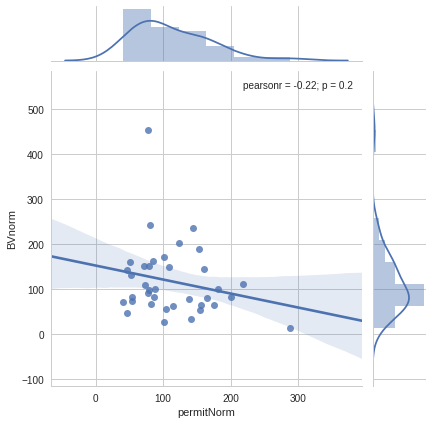

In [534]:
sns.jointplot(x="permitNorm", y="BVnorm", data=BVpermit_BKN, kind="reg")

## Statistical tests and goodness of fit 

In [ ]:
# Spearsman

spearmanr = scipy.stats.spearmanr(np.sort(BVpermit_BKN.permitNorm), np.sort(cb2015[~cb2015.dayride].tripduration))
print ("Spearman's r test result", spearmanr)
if spearmanr[1] >= alpha: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "cannot be rejected (p>=0.05)")
else: 
    print ("The Null hypothesis that the two samples are generated from uncorrelated distributions. " + 
           "is rejected (p = %.3f<0.05)"%spearmanr[1])

In [595]:
BV_permits_norm.columns

Index([u'permitNorm', u'BVnorm', u'HousingUnits', u'renrownRatio',
       u'renterPerc', u'ownerrPerc'],
      dtype='object')

## Multivariate models that include renter/owner occupied...??? >> TBD


In [597]:
# renters and permits model
BVP_multi = smf.ols(formula='BVnorm ~ permitNorm + renterPerc', data=BV_permits_norm).fit()
BVP_multi.summary()
# the model has low predicive power with less than 10% variance explained: Rqueared = 0.062

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BVnorm   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     53.58
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           8.15e-19
Time:                        19:02:38   Log-Likelihood:                -1055.8
No. Observations:                 175   AIC:                             2118.
Df Residuals:                     172   BIC:                             2127.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    393.1216     31.329     12.548      0.000       331.282   454.961
permitNorm    -0.0751      0.066     -1.141      0.256        -0.205     0.055
renterPerc    -3.7440      0.393     -9.517      0.000        -4.521    -2.967
==============================================================================
Omnibus:                       57.259   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.662
Skew:                           1.336   Prob(JB):                     2.89e-36
Kurtosis:                       6.912   Cond. No.                         799.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [598]:
BV_renters = smf.ols(formula='BVnorm ~ renterPerc', data=BV_permits_norm).fit()
BV_renters.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BVnorm   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     105.7
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           1.20e-19
Time:                        19:03:07   Log-Likelihood:                -1056.4
No. Observations:                 175   AIC:                             2117.
Df Residuals:                     173   BIC:                             2123.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    368.8132     22.988     16.044      0.000       323.441   414.185
renterPerc    -3.5229      0.343    -10.280      0.000        -4.199    -2.847
==============================================================================
Omnibus:                       59.747   Durbin-Watson:                   1.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.839
Skew:                           1.392   Prob(JB):                     1.78e-38
Kurtosis:                       7.012   Cond. No.                         200.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

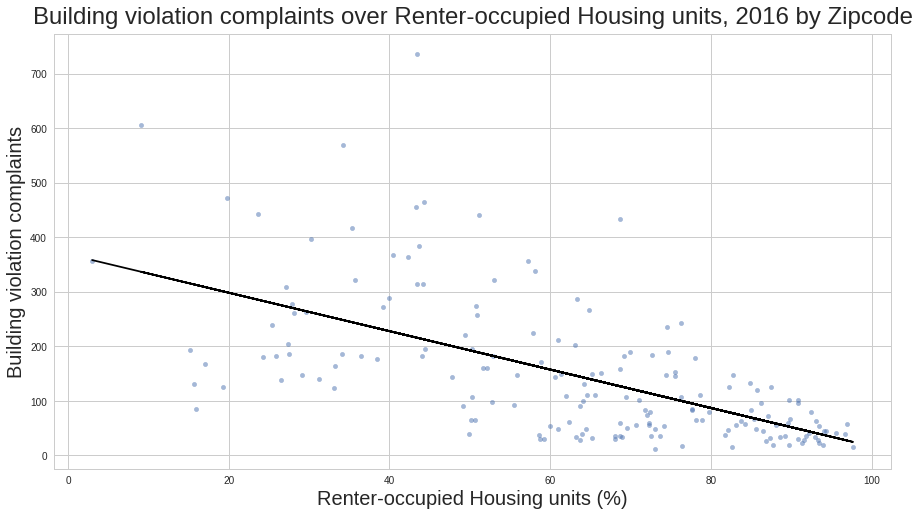

In [601]:
ax = BV_permits_norm.plot.scatter(y="BVnorm", x="renterPerc", alpha=0.5)
ax.plot(BV_permits_norm.renterPerc, BV_renters.fittedvalues, 'k')
ax.set_title("Building violation complaints over Renter-occupied Housing units, 2016 by Zipcode", fontsize=24, y=1.01)
ax.set_ylabel("Building violation complaints", fontsize = 20)
ax.set_xlabel("Renter-occupied Housing units (%)", fontsize = 20);

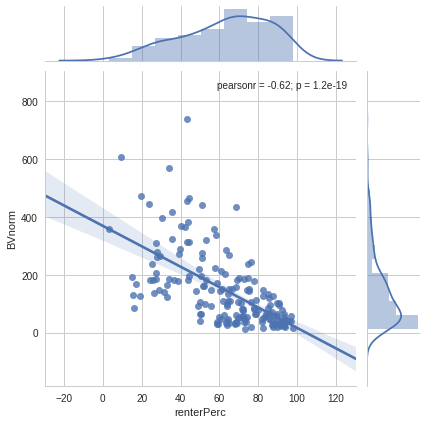

In [602]:
sns.jointplot(x="renterPerc", y="BVnorm", data=BV_permits_norm, kind="reg")

# Spatial Analysis

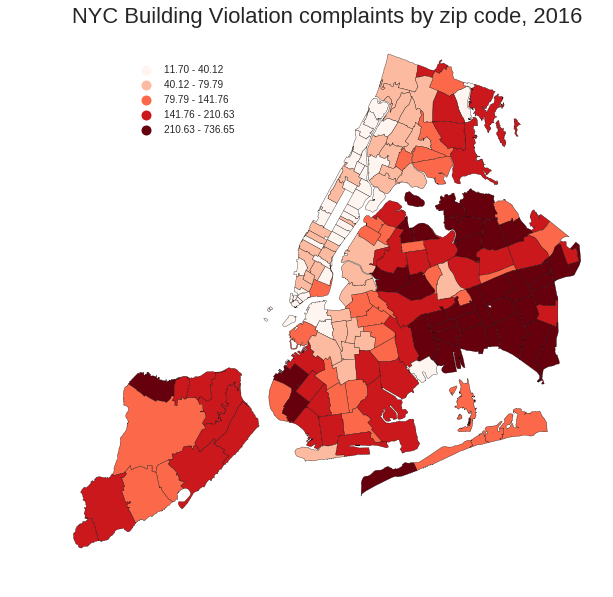

In [590]:
import choroplethNYC as cp

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(BV_permits_shp, column='BVnorm', cmap='Reds', scheme='quantiles', k=5, edgecolor='k', lw=.3, ax=ax)
ax.set_title('NYC Building Violation complaints by zip code, 2016', fontsize=22)

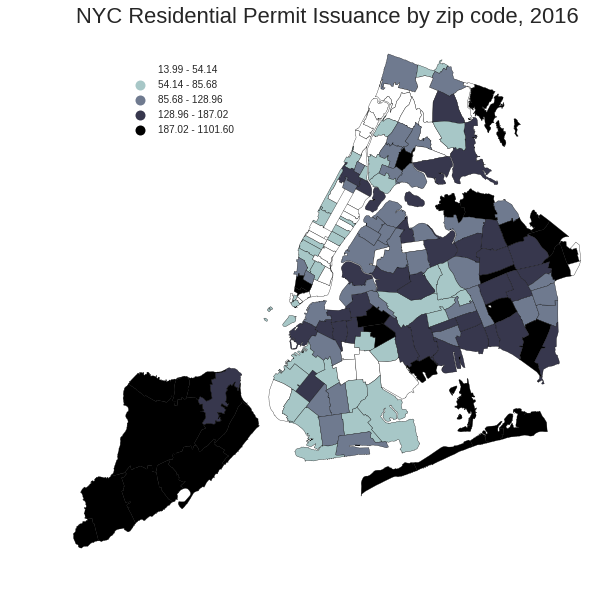

In [594]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(BV_permits_shp, column='permitNorm', cmap='bone_r', scheme='quantiles', k=5, edgecolor='k', lw=.3, ax=ax)
ax.set_title('NYC Residential Permit Issuance by zip code, 2016', fontsize=22)

# Conclusion and future work